In [ ]:
from google.colab import drive
drive.mount('/content/drive')
way = "/content/drive/MyDrive/Colab_Notebooks/aaa_ml/datasets/"

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

In [ ]:
df = pd.read_csv(way + "titanic_train.csv")
df = df[['Age', 'SibSp', 'Sex', 'Survived']]
df.head()

,Age,SibSp,Sex,Survived
0,22.0,1,male,0
1,38.0,1,female,1
2,26.0,0,female,1
3,35.0,1,female,1
4,35.0,0,male,0


In [ ]:
data = df
data = data.fillna({'Age': data.Age.median()})
data['Sex'] = (data['Sex'] == 'male').astype(int)

y = data.Survived.astype(int)

data = data.drop(columns = 'Survived')
data.head()

,Age,SibSp,Sex
0,22.0,1,1
1,38.0,1,0
2,26.0,0,0
3,35.0,1,0
4,35.0,0,1


params = {
    "max_depth": 3,
    "criterion": "gini",
    "min_samples_split": 100,
    "min_samples_leaf": 35,
    "max_features": 1,
    "random_state": 8
}

In [ ]:
params = {
    "max_depth": 3,
    "criterion": "entropy",
    #"min_samples_split": 350,
    "min_samples_leaf": 60,
    "max_features": 1,
    "random_state": 11,
    #"max_leaf_nodes": 4
}

model = DecisionTreeClassifier(**params)
model.fit(data, y)
preds = model.predict(data)


print(preds[data['Sex'] == 0].mean())
print(preds[(data['Sex'] == 1) & (data['Age'] > 9.5)].mean())
print(preds[(data['Sex'] == 1) & (data['Age'] < 9.5) & (data['SibSp'] < 2.5)].mean())
print(preds[(data['Sex'] == 1) & (data['Age'] < 9.5) & (data['SibSp'] >= 2.5)].mean())

1.0
0.0
0.0
0.0


0.73

0.17

0.89

0.05

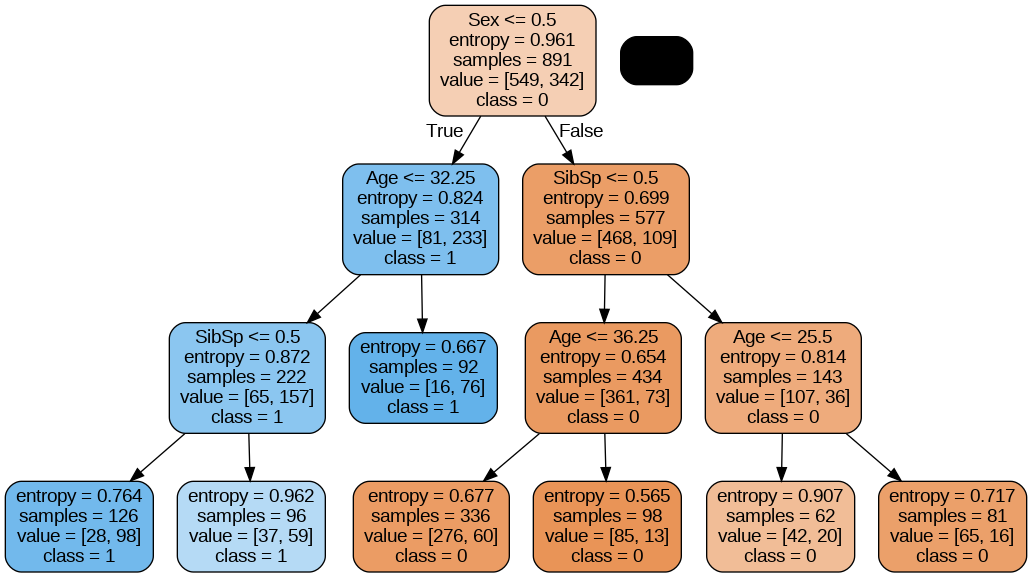

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from IPython.display import Image
import pydotplus

dot_data = export_graphviz(model, out_file=None, feature_names=data.columns.tolist(), class_names=['0', '1'], filled=True, rounded=True)

# Создаем граф из DOT-кода
graph = pydotplus.graph_from_dot_data(dot_data)

# Визуализируем граф в формате PNG
Image(graph.create_png())

In [ ]:
print(preds[data['Sex'] == 0].mean())
print(preds[(data['Sex'] == 1) & (data['Age'] > 9.5)].mean())
print(preds[(data['Sex'] == 1) & (data['Age'] < 9.5) & (data['SibSp'] < 2.5)].mean())
print(preds[(data['Sex'] == 1) & (data['Age'] < 9.5) & (data['SibSp'] >= 2.5)].mean())

0.8121019108280255
0.022018348623853212
1.0
0.07142857142857142


In [ ]:
data['Sex'] == 0

0      False
1       True
2       True
3       True
4      False
       ...  
886    False
887     True
888     True
889    False
890    False
Name: Sex, Length: 891, dtype: bool

In [ ]:
people = data.shape[0]

print(data[data['Sex'] == 0].count() / people)
# print(preds[(data['Sex'] == 1) & (data['Age'] > 9.5)].count())
# print(preds[(data['Sex'] == 1) & (data['Age'] < 9.5) & (data['SibSp'] < 2.5)].count())
# print(preds[(data['Sex'] == 1) & (data['Age'] < 9.5) & (data['SibSp'] >= 2.5)].count())

Age      0.352413
SibSp    0.352413
Sex      0.352413
dtype: float64


# TREE

In [2]:
import numpy as np


class MyDecisionTreeClassifier:

    def __init__(self, max_depth=None, max_features=None, min_leaf_samples=None):
        self.max_depth = max_depth
        self.max_features = max_features
        self.min_leaf_samples = min_leaf_samples
        self._node = {
                        'left': None,
                        'right': None,
                        'feature': None,
                        'threshold': None,
                        'depth': 0,
                        'classes_proba': None
                    }
        self.tree = None  # словарь в котором будет храниться построенное дерево
        self.classes = None  # список меток классов

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.tree = {'root': self._node.copy()}  # создаём первую узел в дереве
        self._build_tree(self.tree['root'], X, y)  # запускаем рекурсивную функцию для построения дерева
        return self

    def predict_proba(self, X):
        proba_preds = []
        for x in X:
            preds_for_x = self._get_predict(self.tree['root'], x)  # рекурсивно ищем лист в дереве соответствующий объекту
            proba_preds.append(preds_for_x)
        return np.array(proba_preds)

    def predict(self, X):
        proba_preds = self.predict_proba(X)
        preds = proba_preds.argmax(axis=1).reshape(-1, 1)
        return preds

    def gini(self, y):
        unique_classes, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return 1 - np.sum(probabilities**2)

    def calc_Q(self, y, y_left, y_right):
        n_m = len(y_left) + len(y_right)
        n_l = len(y_left)
        n_r = len(y_right)

        h_l = self.gini(y_left)
        h_r = self.gini(y_right)

        q_st = self.gini(y)

        q_value = q_st - ((n_l / n_m) * h_l + (n_r / n_m) * h_r)
        return q_value

    def get_best_split(self, X, y):

        features = range(X.shape[1])

        if not self.max_features is None:
            features = np.random.choice(X.shape[1], self.max_features, replace=False)

        best_j = 0
        best_t = 0
        best_q = 0
        best_left_ids = []
        best_right_ids = []

        for feature in features:
          cur_feature = X[:, feature]

          unique_values = np.sort(np.unique(cur_feature))

          for i in range(len(unique_values) - 1):
            value = (unique_values[i] + unique_values[i + 1]) / 2

            left_labels = y[cur_feature <= value]
            right_labels = y[cur_feature > value]

            cur_q = self.calc_Q(y, left_labels, right_labels)

            if cur_q > best_q:
                best_q = cur_q
                best_t = value
                best_j = feature
                best_left_ids = cur_feature <= value
                best_right_ids = cur_feature > value

        return best_j, best_t, best_left_ids, best_right_ids

    def _build_tree(self, curr_node, X, y):

        if curr_node['depth'] == self.max_depth:  # выход из рекурсии если построили до максимальной глубины
            curr_node['classes_proba'] = {c: (y == c).mean() for c in self.classes}  # сохраняем предсказания листьев дерева перед выходом из рекурсии
            return

        if len(np.unique(y)) == 1:  # выход из рекурсии значения если "y" одинковы для все объектов
            curr_node['classes_proba'] = {c: (y == c).mean() for c in self.classes}
            return

        j, t, left_ids, right_ids = self.get_best_split(X, y)  # нахождение лучшего разбиения

        curr_node['feature'] = j  # признак по которому производится разбиение в текущем узле
        curr_node['threshold'] = t  # порог по которому производится разбиение в текущем узле

        left = self._node.copy()  # создаём узел для левого поддерева
        right = self._node.copy()  # создаём узел для правого поддерева

        left['depth'] = curr_node['depth'] + 1  # увеличиваем значение глубины в узлах поддеревьев
        right['depth'] = curr_node['depth'] + 1

        curr_node['left'] = left
        curr_node['right'] = right

        self._build_tree(left, X[left_ids], y[left_ids])  # продолжаем построение дерева
        self._build_tree(right, X[right_ids], y[right_ids])

    def _get_predict(self, node, x):
        if node['threshold'] is None:  # если в узле нет порога, значит это лист, выходим из рекурсии
            return [node['classes_proba'][c] for c in self.classes]

        if x[node['feature']] <= node['threshold']:  # уходим в правое или левое поддерево в зависимости от порога и признака
            return self._get_predict(node['left'], x)
        else:
            return self._get_predict(node['right'], x)


In [ ]:
def read_matrix(n, dtype=float):
    matrix = np.array([list(map(dtype, input().split())) for _ in range(n)])
    return matrix

def read_input_matriсes(n, m, k):
    X_train, y_train, X_test = read_matrix(n), read_matrix(n), read_matrix(k)
    return X_train, y_train, X_test

def print_matrix(matrix):
    for row in matrix:
        print(' '.join(map(str, row)))

def solution():
    n, m, k = map(int, input().split())
    X_train, y_train, X_test = read_input_matriсes(n, m, k)

    clf = MyDecisionTreeClassifier()
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    proba_preds = clf.predict_proba(X_test).round(4)

    print_matrix(preds)
    print_matrix(proba_preds)


solution()

In [11]:
import numpy as np
from collections import Counter


class MyRandomForestClassifier:

    def __init__(self, max_features, n_estimators, max_depth=None, min_leaf_samples=None):
        self.max_features = max_features
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_leaf_samples = min_leaf_samples
        self.trees = []

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        return X[indices], y[indices]

    def fit(self, X, y):
        for _ in range(self.n_estimators):
            tree = MyDecisionTreeClassifier(max_depth=self.max_depth,
                                            max_features=self.max_features,
                                            min_leaf_samples=self.min_leaf_samples)
            X_sample, y_sample = self._bootstrap_sample(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict_proba(self, X):
        all_tree_preds = []
        for tree in self.trees:
            tree_preds = tree.predict_proba(X)
            if tree_preds.shape[1] != len(self.classes):
                adjusted_preds = np.zeros(
                    (tree_preds.shape[0], len(self.classes)))

                for i, class_label in enumerate(self.classes):
                    if class_label in tree.classes:
                        class_idx = np.where(tree.classes == class_label)[0][0]
                        adjusted_preds[:, i] = tree_preds[:, class_idx]
                tree_preds = adjusted_preds
            all_tree_preds.append(tree_preds)
            all_tree_preds.append(tree_preds)

        all_tree_preds = np.mean(all_tree_preds, axis=0)

        return all_tree_preds

    def predict(self, X):
        tree_preds = []
        for tree in self.trees:
            tree_preds.append(tree.predict(X))
        tree_preds = np.array(tree_preds).T
        predictions = [Counter(tree_pred).most_common(1)[0][0] for tree_pred in tree_preds]
        return np.array(predictions)


In [12]:
def read_matrix(n, dtype=float):
    matrix = np.array([list(map(dtype, input().split())) for _ in range(n)])
    return matrix

def read_input_matriсes(n, m, k):
    X_train, y_train, X_test = read_matrix(n), read_matrix(n), read_matrix(k)
    return X_train, y_train, X_test

def print_matrix(matrix):
    for row in matrix:
        print(' '.join(map(str, row)))

def solution():
    n, m, k = map(int, input().split())
    X_train, y_train, X_test = read_input_matriсes(n, m, k)

    rf = MyRandomForestClassifier(max_features=4, n_estimators=200)
    rf.fit(X_train, y_train)

    predictions = rf.predict_proba(X_test)
    print_matrix(predictions)

solution()

3 4 2 
1 0 0 0
2 0 0 0
3 0 0 0
0
1
2
1 0 0 0
2 0 0 0


ValueError: could not broadcast input array from shape (2,2) into shape (2,)

In [ ]:
# 3 4 2
# 1.0 0.0 0.0 0.0
# 2.0 0.0 0.0 0.0
# 3.0 0.0 0.0 0.0
# 0
# 1
# 2
# 1.0 0.0 0.0 0.0
# 2.0 0.0 0.0 0.0